### Random Forest Crocodile Matcher (RF_croc_matcher.ipynb) 

This notebook builds a Random Forest model to classify the **Species** of crocodiles using the provided dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, log_loss
)

#### 1. Dataset Overview & Missing Values

In [2]:
# Load dataset
croc_df = pd.read_csv("crocodile_dataset.csv")

# Preview first rows
display(croc_df.head())

# Display dataset information
print("\nDataset Info:")
croc_df.info()

# Display missing values in table format
print("\nMissing values:")
print(croc_df.isnull().sum())

,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null   object 
 14  Notes                 1000 non-null   object 
dtypes: floa

#### 2. Target Distribution

Common Name counts:
Common Name
New Guinea Crocodile                         68
Borneo Crocodile (disputed)                  67
American Crocodile                           66
Morelet's Crocodile                          64
Cuban Crocodile                              59
Saltwater Crocodile                          58
Philippine Crocodile                         58
Orinoco Crocodile                            58
West African Dwarf Crocodile                 57
Central African Slender-snouted Crocodile    56
West African Slender-snouted Crocodile       55
West African Crocodile                       52
Hall's New Guinea Crocodile                  49
Congo Dwarf Crocodile                        48
Nile Crocodile                               48
Mugger Crocodile (Marsh Crocodile)           47
Siamese Crocodile                            45
Freshwater Crocodile (Johnstone's)           45
Name: count, dtype: int64


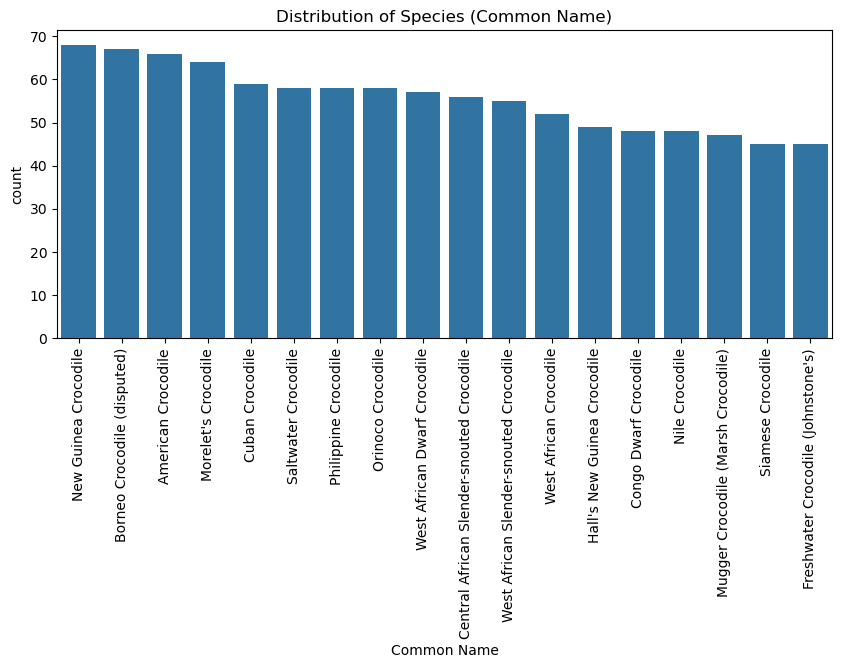

In [3]:
# Show class distribution of the target variable
print("Common Name counts:")
print(croc_df["Common Name"].value_counts())

plt.figure(figsize=(10,4))
sns.countplot(
    data=croc_df, 
    x="Common Name", 
    order=croc_df["Common Name"].value_counts().index
)
plt.xticks(rotation=90)
plt.title("Distribution of Species (Common Name)")
plt.show()

#### 3. Data Cleaning

In [4]:
# Remove the disputed species row
croc_df = croc_df[croc_df["Common Name"] != "Borneo Crocodile (disputed)"]

# Columns that reveal species or are irrelevant
drop_cols = [
    "Observation ID",
    "Observer Name",
    "Notes",
    "Scientific Name",
    "Conservation Status",
    "Family",
    "Genus"
]

# Drop unwanted columns
clean_df = croc_df.drop(columns=drop_cols)

clean_df.head()

,Common Name,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type
0,Morelet's Crocodile,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps
1,American Crocodile,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves
2,Orinoco Crocodile,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas
3,Morelet's Crocodile,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers
4,Mugger Crocodile (Marsh Crocodile),3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers


#### 4. Process Date & Define Features/Target

In [5]:
# Convert string date to datetime object
clean_df["Date"] = pd.to_datetime(clean_df["Date of Observation"], format="%d-%m-%Y")

# Extract year only (day/month unnecessary for our prediction task)
clean_df["Year"] = clean_df["Date"].dt.year

# Remove raw date columns
clean_df = clean_df.drop(columns=["Date", "Date of Observation"])

# Define target column
target = "Common Name"

# Label-encode species names into numeric classes
le = LabelEncoder()
y = le.fit_transform(clean_df[target])

# Feature set = all columns except target
X = clean_df.drop(columns=[target])

clean_df.head()

,Common Name,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Year
0,Morelet's Crocodile,1.90,62.0,Adult,Male,Belize,Swamps,2018
1,American Crocodile,4.09,334.5,Adult,Male,Venezuela,Mangroves,2015
2,Orinoco Crocodile,1.08,118.2,Juvenile,Unknown,Venezuela,Flooded Savannas,2010
3,Morelet's Crocodile,2.42,90.4,Adult,Male,Mexico,Rivers,2019
4,Mugger Crocodile (Marsh Crocodile),3.75,269.4,Adult,Unknown,India,Rivers,2019


#### 5. Train / Test Split & Preprocessing

In [6]:
# Stratified split preserves class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Identify numeric and categorical columns for preprocessing
num_cols = ["Observed Length (m)", "Observed Weight (kg)", "Year"]
cat_cols = ["Age Class", "Sex", "Country/Region", "Habitat Type"]

# ColumnTransformer applies different preprocessing to numeric vs categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

#### 6. Baseline Random Forest Model

In [7]:
# Full modeling pipeline: preprocessing + model
baseline_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])

# Train the baseline model
baseline_pipeline.fit(X_train, y_train)

# Predictions
y_pred_base = baseline_pipeline.predict(X_test)
y_proba_base = baseline_pipeline.predict_proba(X_test)

# Baseline evaluation metrics
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline ROC-AUC:", roc_auc_score(y_test, y_proba_base, multi_class="ovr"))
print("Baseline Log Loss:", log_loss(y_test, y_proba_base))

Baseline Accuracy: 0.9732620320855615
Baseline ROC-AUC: 0.9991468481286292
Baseline Log Loss: 0.2763907693809144


#### 7. Hyperparameter Tuning with GridSearchCV

In [8]:
# Full pipeline for tuning
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])

# Reasonable search space for Random Forest
param_dist = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 10, 20, 40],
    "rf__min_samples_split": [2, 3, 5],
    "rf__min_samples_leaf": [1, 2, 3],
    "rf__max_features": ["sqrt", "log2"],
    "rf__bootstrap": [True, False],
}

# Randomized search
rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=40,               # number of random combinations to try
    scoring="accuracy",
    cv=3,                    # 3-fold CV for speed
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_random.fit(X_train, y_train)

print("\nBest parameters found:")
print(rf_random.best_params_)


Best parameters found:
{'rf__n_estimators': 400, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'log2', 'rf__max_depth': None, 'rf__bootstrap': False}


#### 8. Model Evaluation

In [9]:
# Retrieve best model from grid search
best_rf_pipeline = rf_random.best_estimator_

# Predictions from tuned model
y_pred = best_rf_pipeline.predict(X_test)
y_proba = best_rf_pipeline.predict_proba(X_test)

# Metrics
print("Tuned Accuracy:", accuracy_score(y_test, y_pred))
print("Tuned ROC-AUC (OVR):", roc_auc_score(y_test, y_proba, multi_class="ovr"))
print("Tuned Log Loss:", log_loss(y_test, y_proba))

# Detailed per-class performance
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Tuned Accuracy: 0.9679144385026738
Tuned ROC-AUC (OVR): 0.9996696397866855
Tuned Log Loss: 0.2399429170295088

Classification Report:

                                           precision    recall  f1-score   support

                       American Crocodile       1.00      1.00      1.00        13
Central African Slender-snouted Crocodile       1.00      1.00      1.00        11
                    Congo Dwarf Crocodile       1.00      1.00      1.00         9
                          Cuban Crocodile       1.00      1.00      1.00        12
       Freshwater Crocodile (Johnstone's)       1.00      1.00      1.00         9
              Hall's New Guinea Crocodile       1.00      0.70      0.82        10
                      Morelet's Crocodile       1.00      1.00      1.00        13
       Mugger Crocodile (Marsh Crocodile)       0.88      0.78      0.82         9
                     New Guinea Crocodile       0.82      1.00      0.90        14
                           Nile Cr

#### 9. Confusion Matrix

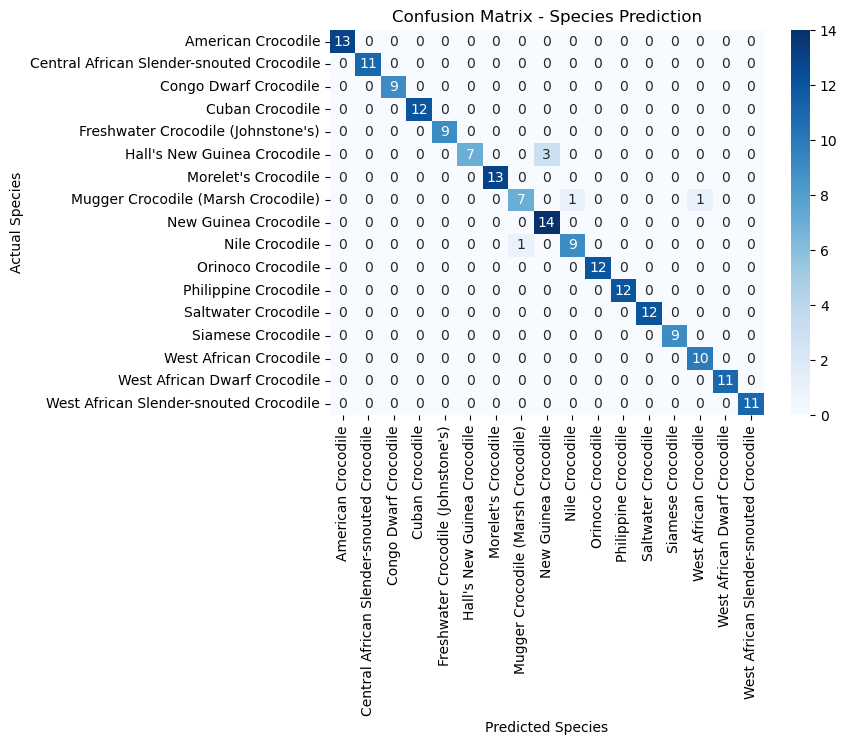

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap for easier interpretation
plt.figure(figsize=(7,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("Confusion Matrix - Species Prediction")
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#### 10. Feature Importance Analysis

Top 15 Important Features:

num__Observed Weight (kg)                 0.100373
num__Observed Length (m)                  0.059142
cat__Country/Region_Cuba                  0.050576
cat__Country/Region_Philippines           0.048807
cat__Country/Region_Papua New Guinea      0.043966
cat__Country/Region_Australia             0.036953
cat__Habitat Type_Shaded Forest Rivers    0.028989
cat__Country/Region_Indonesia (Papua)     0.027004
cat__Habitat Type_Swamps                  0.024203
cat__Country/Region_Congo (DRC)           0.022631
cat__Country/Region_Venezuela             0.021401
cat__Habitat Type_Freshwater Wetlands     0.021325
cat__Habitat Type_Forest Rivers           0.020752
num__Year                                 0.020386
cat__Habitat Type_Flooded Savannas        0.019339
dtype: float64


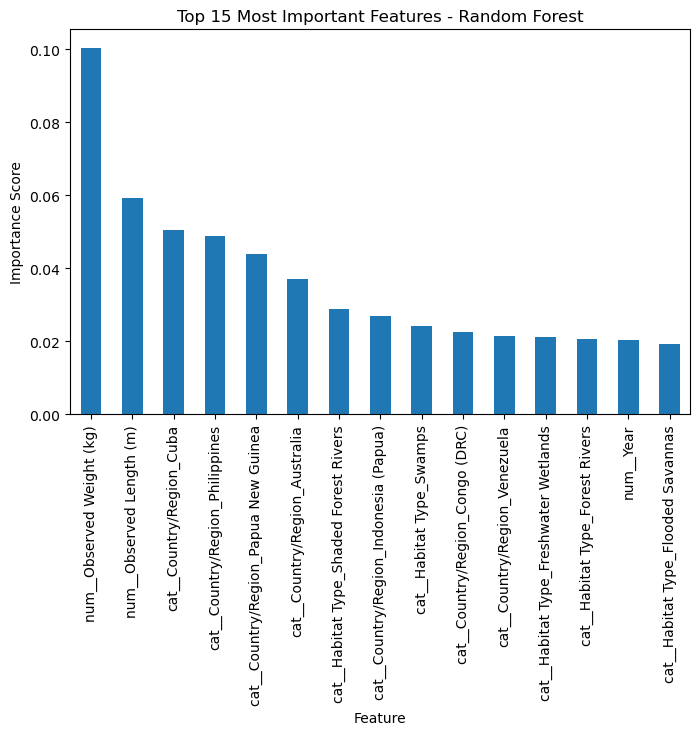

In [11]:
# Extract the trained RF model from the pipeline
rf_model = best_rf_pipeline.named_steps["rf"]
# Get feature names after preprocessing (numeric + one-hot categorical)
feature_names = best_rf_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Map importances to feature names
importances = pd.Series(
    rf_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("Top 15 Important Features:\n")
print(importances.head(15))

plt.figure(figsize=(8, 5))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Most Important Features - Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()